# Visualize GCN Learning Curves

In [163]:
import cPickle
import numpy as np
import time
from time import gmtime, strftime

import math
import os
import sys

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from scipy.signal import argrelextrema

In [164]:
PATH = 'bin/2017-07-20-00:21:11/'
os.listdir(PATH)

['model.h5',
 'epochs.p',
 'epoch_lengths.p',
 'test_metrics.p',
 'train_metrics.p']

In [165]:
epochs = cPickle.load(open(PATH + 'epochs.p'))
epoch_lengths = cPickle.load(open(PATH + 'epoch_lengths.p'))
test_metrics = cPickle.load(open(PATH + 'test_metrics.p'))
train_metrics = cPickle.load(open(PATH + 'train_metrics.p'))
n_graphs = len(train_metrics[0])

In [166]:
# train_metrics[epoch_number][graph_number][iteration_number][loss, acc, val_loss, val_acc]
train_loss = [] # each sublist characterizes a graph
train_acc  = []
val_loss   = []
val_acc    = []
max_i      = []

for graph in xrange(n_graphs):
    _train_loss = []
    _train_acc = []
    _val_loss = []
    _val_acc = []
    for epoch in xrange(epochs[-1] + 1):
        max_iter = len(train_metrics[epoch][0])
        for i in xrange(n_graphs):
            max_iter = max(max_iter, len(train_metrics[epoch][i]))
        if(graph == 0):
            max_i.append(max_iter)
            
        for iteration in xrange(len(train_metrics[epoch][graph])):
            t_loss = train_metrics[epoch][graph][iteration][0]
            t_acc  = train_metrics[epoch][graph][iteration][1]
            v_loss = train_metrics[epoch][graph][iteration][2]
            v_acc  = train_metrics[epoch][graph][iteration][3]

            _train_loss.append(t_loss)
            _train_acc.append(t_acc)
            _val_loss.append(v_loss)
            _val_acc.append(v_acc)
        
        for iteration in range(len(train_metrics[epoch][graph]), max_iter):
            _train_loss.append(float('nan'))
            _train_acc.append(float('nan'))
            _val_loss.append(float('nan'))
            _val_acc.append(float('nan'))
        
    train_loss.append(_train_loss)
    train_acc.append(_train_acc)
    val_loss.append(_val_loss)
    val_acc.append(_val_acc)

In [167]:
#def smooth(x, N):
#    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def smooth(x, N):
    y = np.zeros((len(x),))
    for ctr in range(len(x)):
         y[ctr] = np.sum(x[ctr:(ctr+N)])
    return y/N

N = 5

train_loss = [smooth(loss, N) for loss in train_loss]
val_loss   = [smooth(loss, N) for loss in val_loss]
train_acc  = [smooth(acc, N)  for acc in train_acc]
val_acc    = [smooth(acc, N)  for acc in val_acc]

iters = [max_i[0]]
for i in range(1, len(max_i)):
    iters.append(iters[-1] + max_i[i])

## Standardized Train/Val Plots

In [168]:
def plotX(V, start, end, title="", run_fit=True):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twiny()
    
    ax1.set_title(title)
    
    # Add some extra space for the second axis at the bottom
    fig.subplots_adjust(bottom=.3)
    
    ax1.set_xlabel(r"Number of iterations")
    ax1.set_ylabel(r"Categorical cross-entropy")

    new_tick_locations = np.array([i / (float)(end - start) for i in iters])

    def tick_function(X):
        return ["%d" % i for i in range(0, len(X))]

    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    ax2.spines["bottom"].set_position(("axes", -0.15))

    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    for sp in ax2.spines.itervalues():
        sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)

    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(tick_function(new_tick_locations))
    ax2.set_xlabel(r"Number of Epochs")

    iterations = [i for i in xrange(len(V[0]))][start:end]
    curve_colors = ['b', 'r', 'k', 'm', 'b', 'r', 'k', 'm', 'b', 'r', 'k', 'm']
    
    for g in xrange(n_graphs):
        ax1.plot(iterations, V[g][start:end], curve_colors[g], label="Graph $" + str(g) + "$")
        
        if run_fit:
            m = argrelextrema(V[g][start:end], np.greater, mode='wrap')
            y = [V[g][start:end][m] for i in m]
            ax1.plot(m, y, 'kx')
            fit = np.polyfit(m[0], y[0], deg=1)
            ax1.plot(m[0], fit[0] * m[0] + fit[1], 
                     curve_colors[g] + ':', 
                     linewidth = .5,
                     label="Graph $" + str(g) + "$ maxima")

    ax1.legend()

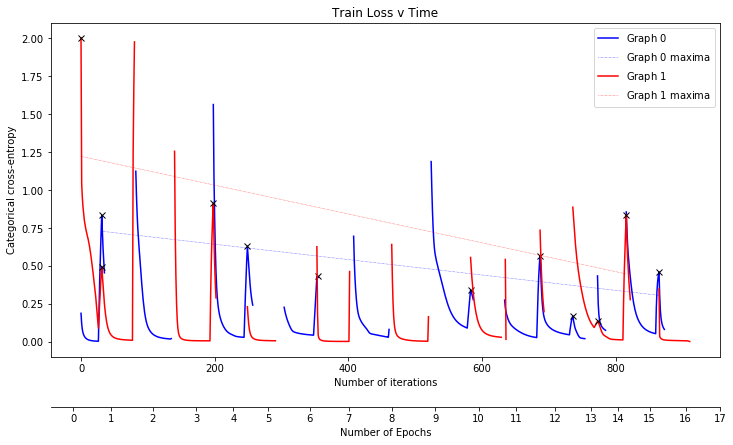

In [169]:
plotX(train_loss, 0, len(train_loss[0]), title="Train Loss v Time")

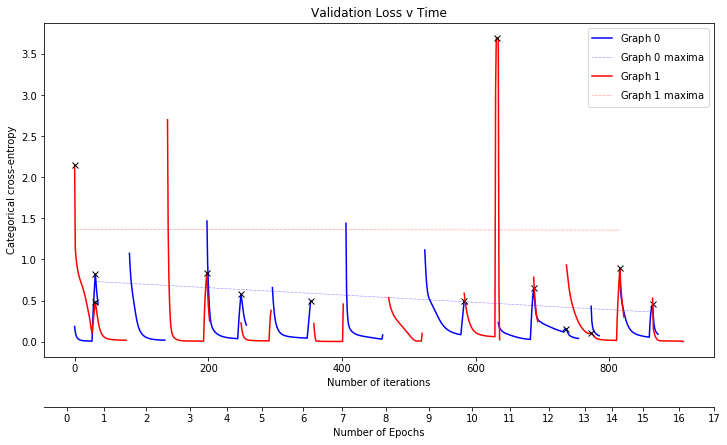

In [170]:
plotX(val_loss, 0, len(val_loss[0]), title="Validation Loss v Time")

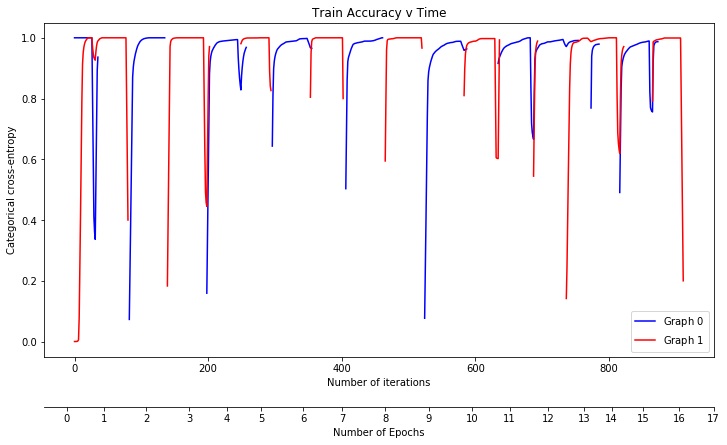

In [171]:
plotX(train_acc, 0, len(train_acc[0]), title="Train Accuracy v Time", run_fit = False)

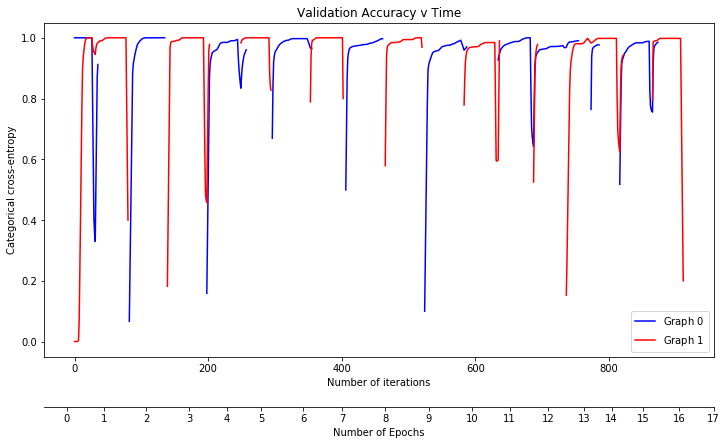

In [172]:
plotX(val_acc, 0, len(val_acc[0]), title="Validation Accuracy v Time", run_fit = False)